In [21]:
import numpy as np
import pandas as pd
import statsrat as sr
from statsrat import latent_cause as lc
#from statsrat.expr.predef.pvl_iti import extinction as task
from statsrat.expr.predef.pvl_no_iti import extinction as task
import seaborn as sb
from plotnine import *

In [37]:
#model = lc.model(name = 'constant', kernel = lc.kernel.constant)
model = lc.model(name = 'power', kernel = lc.kernel.power)
#model = lc.model(name = 'exponential', kernel = lc.kernel.exponential)
#print(model.pars)

#method = 'particle'
method = 'local'
#method = 'both'
perform_oat = False

# It seems that including ITIs makes it hard for the model to detect change points in y values.
# However, that may not be the case for the particle filter.

prior_tau2_x = 1.0
prior_nu_x = 5.0
prior_tau2_y = 0.2
prior_nu_y = 1.0
alpha = 2.0
stick = -0.5
power = 0.5

pm_prec_x = (prior_n*(prior_n + 3))/(prior_n*prior_tau2_x - 0**2)
pm_prec_y = (prior_n*(prior_n + 3))/(prior_n*prior_tau2_y - 0**2)
print('\nprior mean precision for x = ' + str(np.round(pm_prec_x, 2)))
print('prior mean precision for y = ' + str(np.round(pm_prec_y, 2)))

par_vals = {'constant': [prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0],
            'power': [power, prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0],
            'exponential': [gamma, prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0]}


prior mean precision for x = 5.0
prior mean precision for y = 25.0


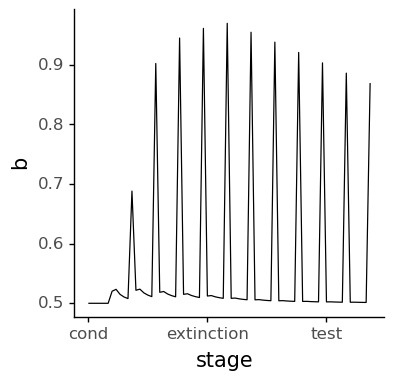

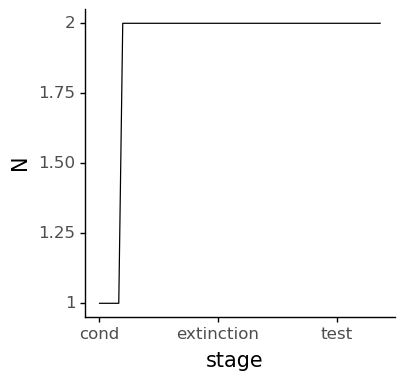

In [38]:
trials = task.make_trials('experimental')

if method == 'particle':
    ds = model.particle_filter(trials, par_vals[model.name], n_p = 50)
    sr.learn_plot(ds, var = 'b').draw()
    sr.learn_plot(ds, var = 'mean_N').draw()
else:
    if method == 'local':
        ds = model.local_vb(trials, par_vals[model.name])
        sr.learn_plot(ds, var = 'b').draw()
        sr.learn_plot(ds, var = 'N').draw()
    else:
        if method == 'both':
            ds_p = model.particle_filter(trials, par_vals[model.name], n_p = 50)
            sr.learn_plot(ds_p, var = 'b').draw()
            ds_l = model.local_vb(trials, par_vals[model.name])
            sr.learn_plot(ds_l, var = 'b').draw()


experimental condition 

[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
ex  ctx  ctx.cs
z              
0    60       0
1     0      12


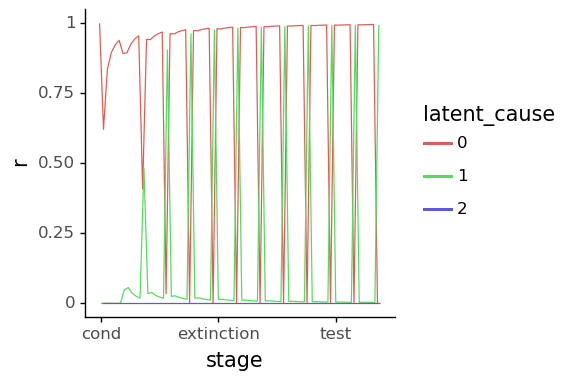

In [39]:
if method == 'local':
    print('experimental condition \n')

    df = ds['z'].to_dataframe()
    table = pd.crosstab(df['z'], df['ex'])
    print(ds['z'].values)
    print(table)
    
    plot_r = sr.learn_plot(ds,
                           var = 'phi_x',
                           rename_coords = {'z_name': 'latent_cause'},
                           sel = {'z_name': ['0', '1', '2']})
    plot_r += ylab('r')
    plot_r.draw()

In [40]:
#df = ds['phi'].loc[{'z_name': ['0', '1', '2']}].to_dataframe().reset_index()
#table = pd.crosstab(values = df['phi'], index = df['z_name'], columns = df['ex'], aggfunc = np.mean)
#print(np.round(table, 5))

In [41]:
#selection = {'z_name': ['0', '1'], 't': range(1, ds['t'].values.shape[0])} # E_log_lik and E_log_prior values wrong for time step 0
#sr.learn_plot(ds, var = 'phi_x', sel = selection)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


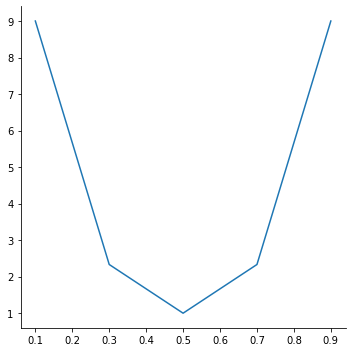

In [42]:
# This pertains to the Bernoulli likelihood, which I'm not using.

prior_mean = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
pi = np.zeros(5)
atn = np.zeros(5)
for i in range(5):
    pi[i] = np.max((prior_mean[i], 1 - prior_mean[i]))
    atn[i] = pi[i]/(1 - pi[i])
sb.relplot(prior_mean, atn, kind = 'line')